In [1]:
import tensorflow as tf
from tensorflow import keras
# Activate GPU 
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    


2023-03-20 18:57:34.947149: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Création des images train et val 

In [44]:
import os, cv2
from shutil import copy2
import numpy as np
import tensorflow as tf 
import random


def crop_blur(xmin,xmax,ymin,ymax, resize, blur, bright, image):
    """
    Crop and blur an image

    Args
    ----
    xmin: int
        x à partir duquel on coupe l'image
    xmax: int
        x jusqu'auquel on coupe l'image (exemple : -80)
    ymin: int
        y à partir duquel on coupe l'image
    ymax: int
        y jusqu'auquel on coupe l'image (exemple : -90)
    resize: float
        facteur de redimensionnement de l'image
    blur: int
        taille du filtre de flou gaussien
    image: np.array
    """
    image = image[ymin:ymax, xmin:xmax]
    image = cv2.resize(image, (0, 0), fx=resize, fy=resize)
    image = cv2.GaussianBlur(image, (blur,blur), 0)
    # Pour finir, on fait varier la luminosité de l'image
    image = cv2.addWeighted(image, bright, np.zeros(image.shape, image.dtype), 0, 0)
    return image

def cercle_random(image, N=2.5):
    x_pos = random.randint(int(image.shape[1]/N), int(image.shape[1]) - int(image.shape[1]/N) - 1)
    y_pos = random.randint(int(image.shape[0]/N), int(image.shape[0]) - int(image.shape[0]/N) - 1)

    centre_cercle = (y_pos, x_pos)
    rayon_cercle = random.randint(min(int(image.shape[0]/N),int(image.shape[0]/N))-1, min(x_pos,y_pos,int(image.shape[0]-y_pos),int(image.shape[1]-x_pos)))

    mask = np.zeros_like(image)
    mask = cv2.circle(mask, centre_cercle, rayon_cercle, (255,255,255), -1)
    image = cv2.bitwise_and(image, mask)
    return(image)

def rectangle_random(image):
    mask = np.zeros(image.shape,np.uint8)
    x_min = random.randint(0, 4)
    y_min = random.randint(0, 4)
    x_max = random.randint(image.shape[0]-4, image.shape[0]-1)
    y_max = random.randint(image.shape[1]-4, image.shape[1]-1)
    mask[y_min:y_max,x_min:x_max] = image[y_min:y_max,x_min:x_max]
    return(mask)


def split_dataset(PATH_DOSS = './images_draft', DATASET_PATH = './dataset', train_images = 750, val_images = 60):
    # Specify path to the folder with all the images
    nom_champions = os.listdir(PATH_DOSS)
    # remove .DS_Store
    nom_champions.remove('.DS_Store')
    # # on enlève la fin des noms des fichiers en "_0.jpg" pour avoir juste le nom du champion
    # for i in range(len(nom_champions)):
    #     nom_champions[i] = nom_champions[i][:-6]


    # On récupère 45 images pour chaque champion pour l'entrainement, et 12 pour la validation
    noms_champions_train = []
    noms_champions_val = []
    for champion in nom_champions:
        for i in range(145):
            noms_champions_train.append(champion+f"{i}")
            if i<29:
                noms_champions_val.append(champion+f"{i}")

    # On en récupère "train_images" pour l'entrainement et "val_images" pour la validation que l'on met dans le dossier dataset au bon endroit
    train_champions = noms_champions_train.copy()
    val_champions = noms_champions_val.copy()
    # Specify path for copying the dataset into train and val sets
    os.makedirs(DATASET_PATH, exist_ok=True)

    # Creating train directory
    train_dir = os.path.join(DATASET_PATH, 'train')
    os.makedirs(train_dir, exist_ok=True)

    # Creating val directory
    val_dir = os.path.join(DATASET_PATH, 'val')
    os.makedirs(val_dir, exist_ok=True) 

    #-------------------------------------------------#
    # On crée des paramètres random pour chaque image
    param_possibles = [(x,y,z,a,b,c,bright) for x in [50] for y in [-80,-90,-100] for z in [60] for a in [-100,-85] for b in [0.15,0.20,0.25,0.30] for c in [3,5,7] for bright in [0.7,0.8,0.9,1]]
    param_possibles_bans = param_possibles_picks = [(x1,-160+x1,y1,-160+y1,resize,blur,bright) for x1 in range(25,125,25) for y1 in range(25,100,25) for resize in [0.20,0.24,0.27] for blur in [3,5] for bright in [0.7,0.8,0.9,1,1.1]]
    param_possibles_picks = [(x1,-160+x1,y1,-160+y1,resize,blur,bright) for x1 in range(25,125,25) for y1 in range(25,100,25) for resize in [0.20,0.24,0.27] for blur in [3,5] for bright in [0.7,0.8,0.9,1,1.1]]

    champions = ['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'AurelionSol', 'Azir', 'Bard', 'Belveth', 'Blitzcrank', 'Brand', 'Braum', 'Caitlyn', 'Camille', 'Cassiopeia', 'Chogath', 'Corki', 'Darius', 'Diana', 'Draven', 'DrMundo', 'Ekko', 'Elise', 'Evelynn', 'Ezreal', 'FiddleSticks', 'Fiora', 'Fizz', 'Galio', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Graves', 'Gwen', 'Hecarim', 'Heimerdinger', 'Illaoi', 'Irelia', 'Ivern', 'Janna', 'JarvanIV', 'Jax', 'Jayce', 'Jhin', 'Jinx', 'Kaisa', 'Kalista', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kayle', 'Kayn', 'Kennen', 'Khazix', 'Kindred', 'Kled', 'KogMaw', 'KSante', 'Leblanc', 'LeeSin', 'Leona', 'Lillia', 'Lissandra', 'Lucian', 'Lulu', 'Lux', 'Malphite', 'Malzahar', 'Maokai', 'MasterYi', 'MissFortune', 'MonkeyKing', 'Mordekaiser', 'Morgana', 'Nami', 'Nasus', 'Nautilus', 'Neeko', 'Nidalee', 'Nilah', 'Nocturne', 'Nunu', 'Olaf', 'Orianna', 'Ornn', 'Pantheon', 'Poppy', 'Pyke', 'Qiyana', 'Quinn', 'Rakan', 'Rammus', 'RekSai', 'Rell', 'Renata', 'Renekton', 'Rengar', 'Riven', 'Rumble', 'Ryze', 'Samira', 'Sejuani', 'Senna', 'Seraphine', 'Sett', 'Shaco', 'Shen', 'Shyvana', 'Singed', 'Sion', 'Sivir', 'Skarner', 'Sona', 'Soraka', 'Swain', 'Sylas', 'Syndra', 'TahmKench', 'Taliyah', 'Talon', 'Taric', 'Teemo', 'Thresh', 'Tristana', 'Trundle', 'Tryndamere', 'TwistedFate', 'Twitch', 'Udyr', 'Urgot', 'Varus', 'Vayne', 'Veigar', 'Velkoz', 'Vex', 'Vi', 'Viego', 'Viktor', 'Vladimir', 'Volibear', 'Warwick', 'Xayah', 'Xerath', 'XinZhao', 'Yasuo', 'Yone', 'Yorick', 'Yuumi', 'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean', 'Zoe', 'Zyra']
    param_par_champ_train = {}
    param_par_champ_val = {}
    for champ in champions:
        param_par_champ_train[champ] = {}
        param_par_champ_val[champ] = {}
        # On choisit aux hasard un certain nombre de configurations
        choix = random.choices(param_possibles, k=10)
        param_par_champ_train[champ]["quality"] = choix
        poss_val = [tuple for tuple in param_possibles if tuple not in choix]
        param_par_champ_val[champ]["quality"] = random.choices(poss_val, k=4)

        choix = random.choices(param_possibles_bans, k=70)
        param_par_champ_train[champ]["ban"] = choix
        poss_val = [tuple for tuple in param_possibles_bans if tuple not in choix]
        param_par_champ_val[champ]["ban"] = random.choices(poss_val, k=12)

        choix = random.choices(param_possibles_picks, k=65)
        param_par_champ_train[champ]["pick"] = choix
        poss_val = [tuple for tuple in param_possibles_picks if tuple not in choix]
        param_par_champ_val[champ]["pick"] = random.choices(poss_val, k=13)


    #-------------------------------------------------#
    # print(train_champions)

    j=0 # compteur pour les images de chaque type
    for i in range(len(train_champions)):
        # Images de qualité réduite
        if j < 10 :
            if j < 10 :
                nom_image = train_champions[i][:-1]
                deb = -1
            else :
                nom_image = train_champions[i][:-2]
                deb = -2
            image = cv2.imread(f"{PATH_DOSS}/{nom_image}/{nom_image}_0.jpg")
            tuple = param_par_champ_train[nom_image]["quality"][j]
            image_pick = crop_blur(tuple[0],tuple[1],tuple[2],tuple[3],tuple[4],tuple[5],tuple[6],image)
            cv2.imwrite(f"{DATASET_PATH}/train/{nom_image}_{train_champions[i][deb:]}.jpg", image_pick)
            j+=1


        # Images de qualité réduite, avec des ronds (simili pick)
        elif j < 75 :
            nom_image = train_champions[i][:-2]
            image = cv2.imread(f"{PATH_DOSS}/{nom_image}/{nom_image}_0.jpg")
            tuple = param_par_champ_train[nom_image]["pick"][j-10]
            image_pick = crop_blur(tuple[0],tuple[1],tuple[2],tuple[3],tuple[4],tuple[5],tuple[6],image)
            image_pick = cercle_random(image_pick)
            cv2.imwrite(f"dataset/train/{nom_image}_{train_champions[i][-2:]}.jpg", image_pick)
            j+=1

        # Images de qualité réduite, avec des rectangles (simili ban)
        else :
            if j < 100 :
                nom_image = train_champions[i][:-2]
                deb = -2
            else :
                nom_image = train_champions[i][:-3]
                deb = -3
            image = cv2.imread(f"{PATH_DOSS}/{nom_image}/{nom_image}_0.jpg")
            tuple = param_par_champ_train[nom_image]["ban"][j-75]
            image_ban = crop_blur(tuple[0],tuple[1],tuple[2],tuple[3],tuple[4],tuple[5],tuple[6],image)
            mask = rectangle_random(image_ban)
            cv2.imwrite(f"dataset/train/{nom_image}_{train_champions[i][deb:]}.jpg", mask)
            j+=1
            # print(train_champions[i])
            if j == 145 : # On a bouclé sur toutes les images d'un champion
                j = 0

    j=0 # compteur pour les images de chaque type pour la validation
    for i in range(len(val_champions)):

        if j < 4 :
            nom_image = val_champions[i][:-1]
            image = cv2.imread(f"{PATH_DOSS}/{nom_image}/{nom_image}_0.jpg")
            tuple = param_par_champ_val[nom_image]["quality"][j]
            image_pick = crop_blur(tuple[0],tuple[1],tuple[2],tuple[3],tuple[4],tuple[5],tuple[6],image)
            cv2.imwrite(f"{DATASET_PATH}/val/{nom_image}_{val_champions[i][-1:]}.jpg", image_pick)
            j+=1

        # Images de qualité réduite, avec des ronds (simili pick)
        elif j < 17 :
            if j < 10 : 
                nom_image = val_champions[i][:-1]
                deb = -1
            else : 
                nom_image = val_champions[i][:-2]
                deb = -2
            image = cv2.imread(f"{PATH_DOSS}/{nom_image}/{nom_image}_0.jpg")
            tuple = param_par_champ_val[nom_image]["pick"][j-4]
            image_pick = crop_blur(tuple[0],tuple[1],tuple[2],tuple[3],tuple[4],tuple[5],tuple[6],image)
            image_pick = cercle_random(image_pick)
            cv2.imwrite(f"dataset/val/{nom_image}_{val_champions[i][deb:]}.jpg", image_pick)
            j+=1

        # Images de qualité réduite, avec des rectangles (simili ban)
        else :
            nom_image = val_champions[i][:-2]
            image = cv2.imread(f"{PATH_DOSS}/{nom_image}/{nom_image}_0.jpg")
            tuple = param_par_champ_val[nom_image]["ban"][j-17]
            image_ban = crop_blur(tuple[0],tuple[1],tuple[2],tuple[3],tuple[4],tuple[5],tuple[6],image)
            mask = rectangle_random(image_ban)
            cv2.imwrite(f"dataset/val/{nom_image}_{val_champions[i][-2:]}.jpg", mask)
            j+=1
            if j == 29 : # On a bouclé sur toutes les images d'un champion
                j = 0

In [45]:
split_dataset()

In [46]:
from keras.applications.resnet import preprocess_input
def resize_images_val():
    for image in os.listdir('./dataset/val/'):
        img = cv2.imread('./dataset/val/' + image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = preprocess_input(img)
        cv2.imwrite('./dataset/val/' + image, img)
resize_images_val()

In [47]:
# Resize each iamge in "./dataset/train/" to 224x224
from keras.applications.resnet import preprocess_input
def resize_images():
    for image in os.listdir('./dataset/train/'):
        img = cv2.imread('./dataset/train/' + image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        img = preprocess_input(img)
        cv2.imwrite('./dataset/train/' + image, img)
resize_images()

### Création de ce qui permet de faire le dataset avec les bons labels et les bonnes tailles

In [48]:
import os
import numpy as np
import cv2
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
# import load_image 


class Generator(tf.keras.utils.Sequence):

    def __init__(self, DATASET_PATH, BATCH_SIZE=32, shuffle_images=True, image_min_side=24):
        """ Initialize Generator object.
        Args
            DATASET_PATH           : Path to folder containing individual folders named by their class names
            BATCH_SIZE             : The size of the batches to generate.
            shuffle_images         : If True, shuffles the images read from the DATASET_PATH
            image_min_side         : After resizing the minimum side of an image is equal to image_min_side.
        """

        self.batch_size = BATCH_SIZE
        self.shuffle_images = shuffle_images
        self.image_min_side = image_min_side
        self.load_image_paths_labels(DATASET_PATH)
        self.create_image_groups()
    
    def load_image_paths_labels(self, DATASET_PATH):
        nom_champions_gen = os.listdir('./images_draft')
        # Le label binarizer permet de transformer les labels en vecteurs de 0 et de 1
        # On enlève .DS_Store qui est un fichier caché
        nom_champions_gen.remove('.DS_Store')
        lb = preprocessing.LabelBinarizer()
        lb.fit(nom_champions_gen)
        # On récupère le nombre de classes, on en a bien 162    
        # print(lb.classes_)

# On lit chaque image et on la met dans une liste, on rajoute avec son label en prenant garde de supprimer le numéro de l'image
        self.image_paths = []
        self.image_labels = []
        for champ in os.listdir(DATASET_PATH):
            champ_nom_temp = os.path.join(DATASET_PATH, champ)
            self.image_paths.append(os.path.join(DATASET_PATH, champ))
            self.image_labels.append(champ[:champ.rfind('_')])
        
        self.image_labels = np.array(lb.transform(self.image_labels), dtype='float32')
        print(self.image_labels.shape)
        
        assert len(self.image_paths) == len(self.image_labels)

    def create_image_groups(self):
        if self.shuffle_images:
            # Randomly shuffle dataset
            seed = 4321
            np.random.seed(seed)
            np.random.shuffle(self.image_paths)
            np.random.seed(seed)
            np.random.shuffle(self.image_labels)

        # Divide image_paths and image_labels into groups of BATCH_SIZE
        self.image_groups = [[self.image_paths[x % len(self.image_paths)] for x in range(i, i + self.batch_size)]
                              for i in range(0, len(self.image_paths), self.batch_size)]
        self.label_groups = [[self.image_labels[x % len(self.image_labels)] for x in range(i, i + self.batch_size)]
                              for i in range(0, len(self.image_labels), self.batch_size)]

    def resize_image(self, img, min_side_len):

        h, w, c = img.shape

        # limit the min side maintaining the aspect ratio
        if min(h, w) < min_side_len:
            im_scale = float(min_side_len) / h if h < w else float(min_side_len) / w
        else:
            im_scale = 1.

        new_h = int(h * im_scale)
        new_w = int(w * im_scale)

        re_im = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        return re_im, new_h / h, new_w / w

    def load_images(self, image_group):

        images = []
        for image_path in image_group:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img, rh, rw = self.resize_image(img, self.image_min_side)
            images.append(img)

        return images

    def construct_image_batch(self, image_group):
        # get the max image shape
        max_shape = tuple(max(image.shape[x] for image in image_group) for x in range(3))

        # construct an image batch object
        image_batch = np.zeros((self.batch_size,) + max_shape, dtype='float32')

        # copy all images to the upper left part of the image batch object
        for image_index, image in enumerate(image_group):
            image_batch[image_index, :image.shape[0], :image.shape[1], :image.shape[2]] = image

        return image_batch
    
    def __len__(self):
        """
        Number of batches for generator.
        """

        return len(self.image_groups)

    def __getitem__(self, index):
        """
        Keras sequence method for generating batches.
        """
        image_group = self.image_groups[index]
        label_group = self.label_groups[index]
        images = self.load_images(image_group)
        image_batch = self.construct_image_batch(images)

        return np.array(image_batch), np.array(label_group)



In [49]:
BASE_PATH = 'dataset'
train_generator = Generator('dataset/train')
val_generator = Generator('dataset/val')
print(len(train_generator))
print(len(val_generator))
image_batch, label_group = train_generator.__getitem__(0)
print(image_batch.shape)
print(label_group.shape)

(23490, 162)
(4698, 162)
735
147
(32, 224, 224, 3)
(32, 162)


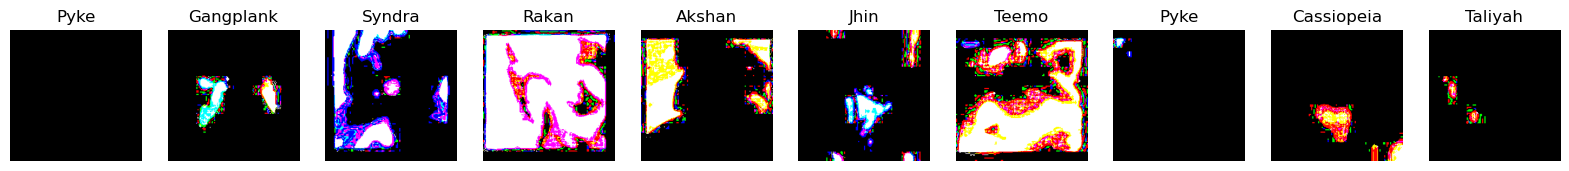

In [50]:
# Afficher 5 images du dataset avec leur label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
%matplotlib inline

champions = ['Aatrox', 'Ahri', 'Akali', 'Akshan', 'Alistar', 'Amumu', 'Anivia', 'Annie', 'Aphelios', 'Ashe', 'AurelionSol', 'Azir', 'Bard', 'Belveth', 'Blitzcrank', 'Brand', 'Braum', 'Caitlyn', 'Camille', 'Cassiopeia', 'Chogath', 'Corki', 'Darius', 'Diana', 'Draven', 'DrMundo', 'Ekko', 'Elise', 'Evelynn', 'Ezreal', 'FiddleSticks', 'Fiora', 'Fizz', 'Galio', 'Gangplank', 'Garen', 'Gnar', 'Gragas', 'Graves', 'Gwen', 'Hecarim', 'Heimerdinger', 'Illaoi', 'Irelia', 'Ivern', 'Janna', 'JarvanIV', 'Jax', 'Jayce', 'Jhin', 'Jinx', 'Kaisa', 'Kalista', 'Karma', 'Karthus', 'Kassadin', 'Katarina', 'Kayle', 'Kayn', 'Kennen', 'Khazix', 'Kindred', 'Kled', 'KogMaw', 'KSante', 'Leblanc', 'LeeSin', 'Leona', 'Lillia', 'Lissandra', 'Lucian', 'Lulu', 'Lux', 'Malphite', 'Malzahar', 'Maokai', 'MasterYi', 'MissFortune', 'MonkeyKing', 'Mordekaiser', 'Morgana', 'Nami', 'Nasus', 'Nautilus', 'Neeko', 'Nidalee', 'Nilah', 'Nocturne', 'Nunu', 'Olaf', 'Orianna', 'Ornn', 'Pantheon', 'Poppy', 'Pyke', 'Qiyana', 'Quinn', 'Rakan', 'Rammus', 'RekSai', 'Rell', 'Renata', 'Renekton', 'Rengar', 'Riven', 'Rumble', 'Ryze', 'Samira', 'Sejuani', 'Senna', 'Seraphine', 'Sett', 'Shaco', 'Shen', 'Shyvana', 'Singed', 'Sion', 'Sivir', 'Skarner', 'Sona', 'Soraka', 'Swain', 'Sylas', 'Syndra', 'TahmKench', 'Taliyah', 'Talon', 'Taric', 'Teemo', 'Thresh', 'Tristana', 'Trundle', 'Tryndamere', 'TwistedFate', 'Twitch', 'Udyr', 'Urgot', 'Varus', 'Vayne', 'Veigar', 'Velkoz', 'Vex', 'Vi', 'Viego', 'Viktor', 'Vladimir', 'Volibear', 'Warwick', 'Xayah', 'Xerath', 'XinZhao', 'Yasuo', 'Yone', 'Yorick', 'Yuumi', 'Zac', 'Zed', 'Zeri', 'Ziggs', 'Zilean', 'Zoe', 'Zyra']
   

def show_images(image_batch, label_group):
    plt.figure(figsize=(20, 10))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(image_batch[i])
        plt.title(champions[np.argmax(label_group[i])])
        plt.axis('off')
    plt.show()

show_images(image_batch, label_group)

### train du modèle

Pour fixer le bug du KeyError : 'accuracy' : remplacer accuracy par acc dans la cellule ci-dessous (dans metrics = ... et dans model_path = ...)

In [51]:
import tensorflow as tf
import os
from tensorflow.keras.optimizers.legacy import Adam

def train(model, train_generator, val_generator, nom_model, epochs = 50):
    model.compile(optimizer=Adam(lr=0.0001),
                    loss='categorical_crossentropy',
                    metrics=['acc'])

    checkpoint_path = './snapshots'
    os.makedirs(checkpoint_path, exist_ok=True)
    model_path = os.path.join(checkpoint_path, 'model_epoch_{epoch:02d}_loss_{loss:.2f}_acc_{acc:.2f}_val_loss_{val_loss:.2f}_val_acc_{val_acc:.2f}.h5')
    
    history = model.fit_generator(generator=train_generator,
                                    steps_per_epoch=len(train_generator),
                                    epochs=epochs,
                                    callbacks=[tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)],
                                    validation_data=val_generator,
                                    validation_steps=len(val_generator))

    model.save(f"recognition_model")

    return history
    

In [52]:
# Import resnet50
from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input, decode_predictions

# Import load image from keras.utils
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array

# Import Model from keras.models
from tensorflow.keras.models import Model

from keras.layers.core import Dense, Dropout, Activation, Flatten

In [53]:
# Load the ResNet50 model
resnet_model = ResNet50(weights='imagenet')

# The below folders are created using utils.py
train_dir = 'dataset/train'
val_dir = 'dataset/val'

# Change the last layer of the model
x = resnet_model.layers[-2].output
predictions = Dense(162, activation='softmax')(x)

model = Model(inputs=resnet_model.input, outputs=predictions)

# If you get out of memory error try reducing the batch size
BATCH_SIZE=5
train_generator = Generator(train_dir, BATCH_SIZE, shuffle_images=True, image_min_side=24)
val_generator = Generator(val_dir, BATCH_SIZE, shuffle_images=True, image_min_side=24)

EPOCHS=5
history = train(model, train_generator, val_generator, "saved_model",  epochs=EPOCHS)



(23490, 162)
(4698, 162)
Epoch 1/5


/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/zp/04t34kkj27ldhv8wcvlpqz300000gn/T/ipykernel_78404/510784955.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,
2023-03-20 20:21:07.341984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4698/4698 [==============================] - ETA: 0s - loss: 0.6627 - acc: 0.8639

2023-03-20 20:28:04.972428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.29146, saving model to ./snapshots/model_epoch_01_loss_0.66_acc_0.86_val_loss_0.29_val_acc_0.93.h5
4698/4698 [==============================] - 448s 94ms/step - loss: 0.6627 - acc: 0.8639 - val_loss: 0.2915 - val_acc: 0.9260
Epoch 2/5
 906/4698 [====>.........................] - ETA: 5:35 - loss: 0.1678 - acc: 0.9570

KeyboardInterrupt: 

In [22]:
# save the model in modeles folder
model.save('./snapshots/model_epoch_02_loss_0.17_acc_0.96_val_loss_0.16_val_acc_0.96.h5')

In [58]:
# laod the model
modelT = tf.keras.models.load_model('./snapshots/model_epoch_01_loss_0.66_acc_0.86_val_loss_0.29_val_acc_0.93.h5')

In [61]:
# import load image from keras.utils et img_to_array
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.resnet import preprocess_input, decode_predictions


img = cv2.imread('../champ1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (224, 224))
imgT = preprocess_input(img)
print(imgT.shape)
# afficher l'image 
plt.imshow(img[0])
preds = modelT.predict(imgT)

# Afficher la prédiction (argmax) et le label correc
print(champions[np.argmax(preds)])




(224, 224, 3)


ValueError: in user code:

    File "/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(32, 224, 3)
